In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, scipy
import anndata
from typing import Dict, Optional
import tables
import scipy.sparse as sp
import scvelo as scv
import scanpy.external as sce
%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# R interfacezziI8a
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri
import rpy2.robjects.numpy2ri
#import numpy2ri

pandas2ri.activate()
anndata2ri.activate()
rpy2.robjects.numpy2ri.activate()

%load_ext rpy2.ipython

# Read CellBender output

In [2]:
def dict_from_h5(file: str) -> Dict[str, np.ndarray]:
    """Read in everything from an h5 file and put into a dictionary.

    Args:
        file: The h5 file

    Returns:
        Dictionary containing all the information from the h5 file
    """
    d = {}
    with tables.open_file(file) as f:
        # read in everything
        for array in f.walk_nodes("/", "Array"):
            d[array.name] = array.read()
    return d

def _fill_adata_slots_automatically(adata, d):
    """Add other information to the adata object in the appropriate slot."""

    # TODO: what about "features_analyzed_inds"?  If not all features are analyzed, does this work?

    for key, value in d.items():
        try:
            if value is None:
                continue
            value = np.asarray(value)
            if len(value.shape) == 0:
                adata.uns[key] = value
            elif value.shape[0] == adata.shape[0]:
                if (len(value.shape) < 2) or (value.shape[1] < 2):
                    adata.obs[key] = value
                else:
                    adata.obsm[key] = value
            elif value.shape[0] == adata.shape[1]:
                if value.dtype.name.startswith('bytes'):
                    adata.var[key] = value.astype(str)
                else:
                    adata.var[key] = value
            else:
                adata.uns[key] = value
        except Exception:
            print('Unable to load data into AnnData: ', key, value, type(value))

def anndata_from_h5(file: str,
                    analyzed_barcodes_only: bool = True) -> anndata.AnnData:
    """Load an output h5 file into an AnnData object for downstream work.

    Args:
        file: The h5 file
        analyzed_barcodes_only: False to load all barcodes, so that the size of
            the AnnData object will match the size of the input raw count matrix.
            True to load a limited set of barcodes: only those analyzed by the
            algorithm. This allows relevant latent variables to be loaded
            properly into adata.obs and adata.obsm, rather than adata.uns.

    Returns:
        anndata.AnnData: The anndata object, populated with inferred latent variables
            and metadata.

    """

    d = dict_from_h5(file)
    X = sp.csc_matrix((d.pop('data'), d.pop('indices'), d.pop('indptr')),
                      shape=d.pop('shape')).transpose().tocsr()

    # check and see if we have barcode index annotations, and if the file is filtered
    barcode_key = [k for k in d.keys() if (('barcode' in k) and ('ind' in k))]
    if len(barcode_key) > 0:
        max_barcode_ind = d[barcode_key[0]].max()
        filtered_file = (max_barcode_ind >= X.shape[0])
    else:
        filtered_file = True

    if analyzed_barcodes_only:
        if filtered_file:
            # filtered file being read, so we don't need to subset
            print('Assuming we are loading a "filtered" file that contains only cells.')
            pass
        elif 'barcode_indices_for_latents' in d.keys():
            X = X[d['barcode_indices_for_latents'], :]
            d['barcodes'] = d['barcodes'][d['barcode_indices_for_latents']]
        elif 'barcodes_analyzed_inds' in d.keys():
            X = X[d['barcodes_analyzed_inds'], :]
            d['barcodes'] = d['barcodes'][d['barcodes_analyzed_inds']]
        else:
            print('Warning: analyzed_barcodes_only=True, but the key '
                  '"barcodes_analyzed_inds" or "barcode_indices_for_latents" '
                  'is missing from the h5 file. '
                  'Will output all barcodes, and proceed as if '
                  'analyzed_barcodes_only=False')

    # Construct the anndata object.
    adata = anndata.AnnData(X=X,
                            obs={'barcode': d.pop('barcodes').astype(str)},
                            var={'gene_name': (d.pop('gene_names') if 'gene_names' in d.keys()
                                               else d.pop('name')).astype(str)},
                            dtype=X.dtype)
    adata.obs.set_index('barcode', inplace=True)
    adata.var.set_index('gene_name', inplace=True)

    # For CellRanger v2 legacy format, "gene_ids" was called "genes"... rename this
    if 'genes' in d.keys():
        d['id'] = d.pop('genes')

    # For purely aesthetic purposes, rename "id" to "gene_id"
    if 'id' in d.keys():
        d['gene_id'] = d.pop('id')

    # If genomes are empty, try to guess them based on gene_id
    if 'genome' in d.keys():
        if np.array([s.decode() == '' for s in d['genome']]).all():
            if '_' in d['gene_id'][0].decode():
                print('Genome field blank, so attempting to guess genomes based on gene_id prefixes')
                d['genome'] = np.array([s.decode().split('_')[0] for s in d['gene_id']], dtype=str)

    # Add other information to the anndata object in the appropriate slot.
    _fill_adata_slots_automatically(adata, d)

    # Add a special additional field to .var if it exists.
    if 'features_analyzed_inds' in adata.uns.keys():
        adata.var['cellbender_analyzed'] = [True if (i in adata.uns['features_analyzed_inds'])
                                            else False for i in range(adata.shape[1])]
    elif 'features_analyzed_inds' in adata.var.keys():
        adata.var['cellbender_analyzed'] = [True if (i in adata.var['features_analyzed_inds'].values)
                                            else False for i in range(adata.shape[1])]

    if analyzed_barcodes_only:
        for col in adata.obs.columns[adata.obs.columns.str.startswith('barcodes_analyzed')
                                     | adata.obs.columns.str.startswith('barcode_indices')]:
            try:
                del adata.obs[col]
            except Exception:
                pass
    else:
        # Add a special additional field to .obs if all barcodes are included.
        if 'barcodes_analyzed_inds' in adata.uns.keys():
            adata.obs['cellbender_analyzed'] = [True if (i in adata.uns['barcodes_analyzed_inds'])
                                                else False for i in range(adata.shape[0])]
        elif 'barcodes_analyzed_inds' in adata.obs.keys():
            adata.obs['cellbender_analyzed'] = [True if (i in adata.obs['barcodes_analyzed_inds'].values)
                                                else False for i in range(adata.shape[0])]

    return adata

In [3]:
adata = anndata_from_h5('CellBender/d16_cellbender_output_file.h5')
adata.obs.index.name = None
adata.var.index.name = None
adata.X = adata.X.astype(np.float64)
del adata.uns
del adata.obsm
adata.layers['counts'] = adata.X
adata.var_names_make_unique()

adata_var_meta = adata.var

In [11]:
adata.obs

,background_fraction,cell_probability,cell_size,droplet_efficiency,sampleID,nCount_HTO,nFeature_HTO
CAATGACCATCATTTC-1,0.002663,0.999955,12338.407227,1.661432,Doublet,609.0,4
TCCTCTTTCTGGCCAG-1,0.001832,0.999955,13452.353516,2.246240,ZA60-ARC-d16-AGTAAGTTCAGCGTA,1115.0,4
CATGGTAGTGACAGGT-1,0.004476,0.999955,11683.941406,1.448634,ZA60-ARC-d16-AGTAAGTTCAGCGTA,925.0,4
GGAACCCAGACTTCAC-1,0.006781,0.999955,11200.260742,1.525857,ZA60-ARC-d16-AGTAAGTTCAGCGTA,711.0,4
TTGCATTCAATAACGA-1,0.002208,0.999955,14159.618164,2.278516,Doublet,1511.0,4
...,...,...,...,...,...,...,...
TCCTCCCGTACTGACT-1,0.048250,0.999967,8179.209473,1.058873,ZA57-ARC-d16-GTCAACTCTTTAGCG,339.0,4
GGAGGTATCTACCACC-1,0.004685,0.999955,13329.463867,1.281293,ZA57-ARC-d16-GTCAACTCTTTAGCG,745.0,4
ATCGCCTGTTAGGGTG-1,0.023729,0.999948,8955.646484,1.161671,ZA57-ARC-d16-GTCAACTCTTTAGCG,365.0,4
TGACCCTCACCTGATA-1,0.005318,0.999955,12019.426758,1.333510,Doublet,1088.0,4


# Sample assignment (HTO calling)

In [5]:
%%R
library(dplyr)
library(assertthat)
library(ggplot2)
library(mclust)
library(diptest)
library(intrinsicDimension)

HTODemux.mcl <- function(object, assay = "HTO", q_l = 1, q_h = 0.005, seed = 42){
  # A function to find the threshold for each hastag, the P, and singlet, doublets and negative.
  # The input is the HTO data matrix (normalized across cells).
  
  assay <- assay %||% DefaultAssay(object = object)
  data <- GetAssayData(object = object, assay = assay, slot = 'data')
  hto.cutoff.metadata = data.frame(cut_off = future.apply::future_apply(data,1,function(x) select_hash_cutoff_mcl(x, q_l = q_l, q_h = q_h), future.seed = T))
  hto.cutoff.metadata$Multi_modal = apply(data,1,function(x) is_multimodal(x))
  hto_mcl.p = t(apply(data,1,function(x) hash_mcl_p(x, seed = seed, q_l = q_l, q_h = q_h)))
  discrete <- data
  discrete[discrete > 0] <- 0
  for (iter in rownames(x = data)) {
    values <- data[iter, ]
    cutoff <- hto.cutoff.metadata[iter,'cut_off']
    discrete[iter, names(x = which(x = values > cutoff))] <- 1
  }
  classification.metadata <- HTO_classifcation(discrete, hto_mcl.p, assay)
  object <- AddMetaData(object = object, metadata = classification.metadata)
  Idents(object) <- paste(assay, "calledFeatures", sep = '_')
  doublets <- rownames(x = object[[]])[which(object[[paste(assay, 'globalClass', sep = "_")]] == "Doublet")]
  Idents(object = object, cells = doublets) <- "Doublet"
  Idents(object) = factor(Idents(object), levels = c('Doublet', 'Negative', rownames(object@assays$HTO)))
  object$sampleID <- Idents(object = object)
  return(object)
}

is_multimodal <- function(x, p.cutoff = 1e-2) {
  # Test if the expression distribution violates unimodal distribution.
  p = diptest::dip.test(x)$p.value
  return(p < p.cutoff)
}

select_hash_cutoff_mcl <- function(x, q_l = 1, q_h = 0.01, seed = 42) {
  # Model HTO data as a mixture of two Gaussian distributions (for normalized [across cells] data)
  # And select HTO cutoff based on mclust (Model based clustering).
  assertthat::assert_that(class(x) == "numeric")
  assertthat::is.number(seed)
  assertthat::assert_that(length(seed) == 1)
  set.seed(seed)
  km <- mclust::Mclust(data = x, G = 2, verbose = F)
  cl <- km$classification
  cl_center = km$parameters$mean
  high_cl <- which(cl_center == max(cl_center))
  low_cl <- which(cl_center != max(cl_center))
  # q_l and q_h are the quantiles for negative and postive cluster, respectively. 
  cutoff <- max(quantile(x[cl == low_cl], q_l), quantile(x[cl == high_cl], q_h))
  # The higher the cut off, the less false positive (the more false negative).
  return(cutoff)
}

hash_mcl_p <- function(x, seed = 3030, q_l = 1, q_h = 0.001) {
  assertthat::assert_that(class(x) == "numeric")
  assertthat::is.number(seed)
  assertthat::assert_that(length(seed) == 1)
  set.seed(seed)
  km <- mclust::Mclust(data = x, G = 2, verbose = F)
  cl <- km$classification
  cl_center = km$parameters$mean
  high_cl <- which(cl_center == max(cl_center))
  low_cl <- which(cl_center != max(cl_center))
  p.high_cl <- km$z[,high_cl]
  # Correct assignment error from Mclust
  p.high_cl[which(x < max(quantile(cl_center[low_cl], q_l), quantile(cl_center[low_cl], q_h)))] = 0
  names(p.high_cl) = names(x)
  return(p.high_cl)
}

HTO_classifcation = function(discrete, hto_mcl.p, assay){
  # Based on HTODemux (Seurat)
  npositive <- colSums(x = discrete)
  classification.global <- npositive
  classification.global[npositive == 0] <- "Negative"
  classification.global[npositive == 1] <- "Singlet"
  classification.global[npositive > 1] <- "Doublet"
  donor.id = rownames(x = discrete)
  hash.max <- apply(X = hto_mcl.p, MARGIN = 2, FUN = max) # This returns the probability of the most likely HashID (based on the Hashtag distribution among cells)
  hash.maxID <- as.character(donor.id[apply(X = hto_mcl.p, MARGIN = 2, FUN = which.max)])
  hash.second <- apply(X = hto_mcl.p, MARGIN = 2, FUN = function(x) sort(x,decreasing = T)[2])
  hash.secondID <- as.character(donor.id[apply(X = hto_mcl.p, MARGIN = 2, FUN = function(x) order(x,decreasing = T)[2])])
  hash.margin <- hash.max - hash.second
  doublet_id <- sapply(X = 1:length(x = hash.maxID), FUN = function(x) {
    return(paste(sort(x = c(hash.maxID[x], hash.secondID[x])), 
                 collapse = "_"))
  })
  classification <- classification.global
  classification[classification.global == "Negative"] <- "Negative"
  classification[classification.global == "Singlet"] <- hash.maxID[which(x = classification.global == "Singlet")]
  classification[classification.global == "Doublet"] <- doublet_id[which(x = classification.global == "Doublet")]
  classification.metadata <- data.frame(hash.maxID, hash.secondID, hash.margin, classification, classification.global)
  colnames(x = classification.metadata) <- paste(assay, c("primaryID", "secondaryID", "margin", "calledFeatures", "globalClass"), sep = "_")
  return(classification.metadata)
}

        
                                               
my.cols <- c('Doublet' = '#E56786','Negative' = '#0000FF','Singlet' = '#7E9D00',
             'Called' = '#C1E24D','Uncalled' = '#FFB2FF', 'intra-doublet' = '#FFA500',
             'Highlight' = '#de3163','Lowlight' = '#f4b8c9','Greyneric' = '#878686')

base.size = 10
plotting.font <- 'Helvetica'

exponent_format <- function() {
  function(x) {
    parse(text = gsub("e\\+?", " %*% 10^", scales::scientific_format()(x)))
  }
}

make_plot_htoThresh <- function(hto.sample.calling.metadata, hto.cutoff.metadata, index) {
  
  hto.cutoff.metadata[['hto']] <- hto.cutoff.metadata[['hto_name']]
  
  p <- ggplot(hto.sample.calling.metadata, aes(x = expression, fill = above_cutoff)) +
    geom_histogram(bins = 100) +
    facet_wrap(~sample_id, scales = 'free',ncol = 3) +
    xlab('Expression (CLR-norm)') +
    ylab('UMI counts (HTO)') +
    scale_y_log10(labels = exponent_format()) +
    scale_fill_manual(name = '',
                      labels = c('HTO negative','HTO positive'),
                      values = c(my.cols[['Uncalled']],my.cols[['Called']]),
                      guide = guide_legend(override.aes = list(fill = c(my.cols[['Uncalled']],my.cols[['Called']])))) +
    ggtitle(index) +
    theme_minimal(base_size = base.size) +
    theme(text = element_text(family = plotting.font), legend.position = 'bottom')
  
  p <- patchwork::wrap_plots(p)
  return(p)
}
                


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

                   __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1
Type 'citation("mclust")' for citing this R package in publications.
Loading required package: yaImpute

Attaching package: ‘yaImpute’

The following object is masked from ‘package:ggplot2’:

    vars

The following object is masked from ‘package:dplyr’:

    vars




    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
     |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |+                                                 | 2 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |+++                                               | 6 % ~00s           |++++                                              | 7 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++      

Attaching SeuratObject

Attaching package: ‘Seurat’

The following object is masked from ‘package:SummarizedExperiment’:

    Assays

Loading required package: scuttle
Loading required package: ggrepel

Attaching package: ‘PCAtools’

The following object is masked from ‘package:scran’:

    parallelPCA

The following objects are masked from ‘package:stats’:

    biplot, screeplot

Normalizing across cells
In addition: Warning messages:
1: In scale_y_log10(labels = exponent_format()) :
  log-10 transformation introduced infinite values.
2: Removed 433 rows containing missing values or values outside the scale range
(`geom_bar()`). 


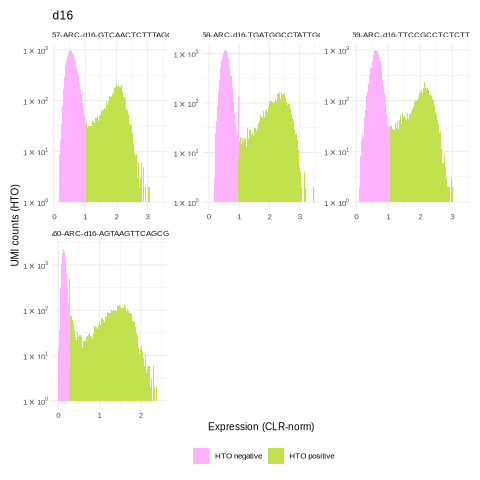

In [6]:
%%R -i adata -o adata_hto

Csparse_validate = "CsparseMatrix_validate"
library(Seurat)
library(Matrix)
library(scater)
library(scran)
library(scDblFinder)
library(PCAtools)

hto_matrix_dir = "Cite_seq_count_d16/umi_count/"
barcode.path <- paste0(hto_matrix_dir, "barcodes.tsv.gz")
features.path <- paste0(hto_matrix_dir, "features.tsv.gz")
matrix.path <- paste0(hto_matrix_dir, "matrix.mtx.gz")
hto_matrix <- readMM(file = matrix.path)
feature.names = read.delim(features.path, header = FALSE, stringsAsFactors = FALSE)
barcode.names = read.delim(barcode.path, header = FALSE, stringsAsFactors = FALSE)
colnames(hto_matrix) = barcode.names$V1
rownames(hto_matrix) = feature.names$V1
# Removing the unmapped feature from the HTO matrix
hto_matrix <- hto_matrix[!(rownames(hto_matrix) %in% 'unmapped'),]



sobj <- as.Seurat(adata, counts='counts', data=NULL)

# Ensure similar naming pattern between the colnames in hto and transcriptome matrix
colnames(hto_matrix) <- paste(colnames(hto_matrix), "-1", sep="")

# Select cell barcodes detected by both RNA and HTO 
joint_barcodes <- intersect(colnames(sobj), colnames(hto_matrix))

# Subset RNA and HTO counts by joint cell barcodes
sobj = subset(sobj, cells=joint_barcodes)
hto_matrix <- hto_matrix[, joint_barcodes]

# Add HTO data as a new assay independent from RNA
sobj[["HTO"]] <- CreateAssayObject(counts = hto_matrix)

# Normalize HTO data, here we use centered log-ratio (CLR) transformation
sobj <- NormalizeData(sobj, assay = "HTO", normalization.method = "CLR", margin=2)


q_l <- 1
q_h <- 0.001


sobj <- HTODemux.mcl(sobj, q_l = q_l, q_h = q_h)   


# Plotting
tmp.assay <- DefaultAssay(object = sobj)
tmp.data <- GetAssayData(object = sobj, assay = 'HTO', slot = 'data')
hto.data.wide = data.frame(t(tmp.data))
colnames(hto.data.wide) <- gsub("[.]", "-", colnames(hto.data.wide), perl = T)
hto.data.long = data.table::melt(data.table::setDT(hto.data.wide,keep.rownames = T), id.vars = 'rn', value.name = 'expression',variable.name = 'sample_id')
#hto.data.long <- rename(hto.data.long, 'CB' = 'rn')
hto.data.long[, sample_id := as.character(sample_id)]

hto_mcl.cutoff = data.table::data.table(cut_off = future.apply::future_apply(tmp.data,1,function(x) select_hash_cutoff_mcl(x, q_l = q_l, q_h = q_h), future.seed = T), hto_name = colnames(hto.data.wide)[-1], key = "hto_name")
hto.data.long[, above_cutoff := expression > hto_mcl.cutoff[sample_id, cut_off]]

hto.sample.calling.metadata <- hto.data.long
hto.cutoff.metadata <- hto_mcl.cutoff

p.hto.barcode.calling <- make_plot_htoThresh(hto.sample.calling.metadata,hto.cutoff.metadata, 'd16')
print(p.hto.barcode.calling)

adata_hto = as.SingleCellExperiment(sobj)   

In [7]:
common_cells = list(set(adata.obs_names) & set(adata_hto.obs_names))
adata = adata[common_cells].copy()
adata.obs['sampleID'] = adata_hto.obs['sampleID']
adata.obs['nCount_HTO'] = adata_hto.obs['nCount_HTO']
adata.obs['nFeature_HTO'] = adata_hto.obs['nFeature_HTO']

In [8]:
%%R
library(Rtsne)

process_seur <- function(seur, n.pca.dims = 50, assay = 'originalexp', verbose = F) {
  cat('#\t..\tprocessing ',assay,'-assay..\n', sep = '')
  suppressWarnings({
    if (assay == 'originalexp') {
      cat('#\t..\t\trunning sctransform..\n')
      seur <- SCTransform(seur, assay = 'originalexp', method = 'qpoisson', verbose = verbose)
      cat('#\t..\t\trunning PCA..\n')
      seur <- RunPCA(seur, assay = 'SCT', verbose = verbose)
      cat('#\t..\t\testimating global dims..\n')
      dims <- round(
        as.numeric(
          maxLikGlobalDimEst(
            data = seur@reductions[['pca']][, 1:n.pca.dims],
            k = 20)))
      cat('#\t..\t\t\tdims:\t',dims,'\n')
      cat('#\t..\t\trunning tSNE..\n')
      seur <- RunTSNE(seur, assay = 'SCT', dims = seq(dims), verbose = verbose, check_duplicates = FALSE)
      cat('#\t..\t\trunning UMAP..\n')
      seur <- RunUMAP(seur, assay = 'SCT', dims = seq(dims), verbose = verbose)
      cat('#\t..\t\trunning FindNeighbors..\n')
      seur <- FindNeighbors(seur, assay = 'SCT', dims = seq(dims), verbose = verbose)
      cat('#\t..\t\trunning FindClusters..\n')
      seur <- FindClusters(seur, assay = 'SCT', verbose = verbose)
    }
    if (assay == 'HTO') {
      cat('#\t..\t\trunning PCA..\n')
      seur <- ScaleData(seur,
                        assay = 'HTO',
                        features = rownames(seur[['HTO']]@counts),
                        verbose = verbose)
      seur <- RunPCA(seur,
                     assay = 'HTO',
                     features = rownames(seur[['HTO']]@counts),
                     reduction.name = 'hto.pca',
                     reduction.key = 'htoPC_',
                     approx=FALSE,
                     verbose = verbose)
      
      cat('#\t..\t\trunning tSNE..\n')
      seur <- RunTSNE(seur,
                      distance.matrix = as.matrix(dist(t(GetAssayData(object = seur, assay = 'HTO')))),
                      reduction.name = 'hto.tsne',
                      reduction.key = 'htotSNE_',
                      verbose = verbose,
                      check_duplicates = FALSE)
      
      cat('#\t..\t\trunning UMAP..\n')
      seur <- RunUMAP(seur,
                      reduction = "hto.pca",
                      dims = seq(rownames(seur@assays$HTO)),
                      reduction.name = 'hto.umap',
                      reduction.key = 'htoUMAP_',
                      metric='correlation',
                      verbose = verbose)
    }
  })
  return(seur)
}

make_plot_htotsne <- function(meta.data) {
    tmp.color.palette <- c(my.cols[['Doublet']],
                           my.cols[['Negative']],
                           my.cols[['Singlet']],
                           my.cols[['intra-doublet']])

    p <- ggplot(meta.data) +
      geom_point(aes(x = HTO_tsne1, y = HTO_tsne2, col = HTO_globalClass, alpha = .25)) +
      scale_color_manual(values = tmp.color.palette) +
      labs(x = 'tSNE 1', y = 'tSNE 2', color = 'HTO classification') +
      theme_minimal(base_size = base.size) +
      guides(alpha = 'none') +
      theme(text = element_text(family = plotting.font), legend.position = 'bottom') 
    

    p <- patchwork::wrap_plots(p)
    return(p)
}

dub_cutoff <- function(x) {
  
  # calculate number of neighbors at each proportion that are doublets
  data.frame("proportion" = x$RNA_doubletNeighborProportion) %>% 
    group_by(proportion) %>% 
    summarize(n_cells = n()) %>% 
    mutate(pct_cells = n_cells / sum(n_cells)) -> data 
  
  
  # find point at which we gain very few doublets as proportion increases 
  cut <- data$proportion[PCAtools::findElbowPoint(variance = sort(data$n_cells, decreasing = T)) + 1]
  vec <- if_else(x$RNA_doubletNeighborProportion <= cut, F, T)
  
  data[['cut']] <- cut
  
  
  return(vec)
  
}




sobj_temp <- subset(x = sobj,subset=nCount_originalexp > 0)

# identify intra-hash doublets                                                                             
sobj_temp <- process_seur(sobj_temp,assay = 'HTO')

sce.full <- as.SingleCellExperiment(sobj_temp)
sce.full <- logNormCounts(sce.full)
dec.hash <- modelGeneVar(sce.full)

top.hash <- getTopHVGs(dec.hash, n = 1000)
sce.full <- runPCA(sce.full, subset_row = top.hash, ncomponents = 20)
sce.full[['HTO_doubletBool']] <- if_else(sce.full[['sampleID']] == 'Doublet', true = T, false = F)


# Recovering the intra-sample doublets:
cat('#\t..\trecovering intra-sample doublets..\n')
hashed.doublets <- scDblFinder::recoverDoublets(sce.full,
                                              use.dimred = 'PCA',
                                              doublets = sce.full[['HTO_doubletBool']],
                                              samples = table(sce.full[['sampleID']]))

sce.full[['RNA_doubletNeighborProportion']] <- hashed.doublets[['proportion']]
sce.full[['RNA_recoveredDoubletBool']] <- hashed.doublets[['predicted']]

cat('#\t..\trecovering doublet neighbors..\n')
sce.full[['RNA_doubletNeighborBool']] <- dub_cutoff(sce.full)

sobj_temp[['HTO_doubletBool']] <- sce.full[['HTO_doubletBool']]
sobj_temp[['RNA_recoveredDoubletBool']] <- sce.full[['RNA_recoveredDoubletBool']]
sobj_temp[['RNA_doubletNeighborBool']] <- sce.full[['RNA_doubletNeighborBool']]
sobj_temp[['RNA_doubletNeighborProportion']] <- sce.full[['RNA_doubletNeighborProportion']]

sobj_temp[['HTO_globalClass']][sobj_temp[['RNA_recoveredDoubletBool']] == T] <- 'intra-doublet'  
#sobj[['sampleID']][sobj[['RNA_recoveredDoubletBool']] == T] <- 'intra-doublet'                                                                              


sobj_temp <- process_seur(sobj_temp, assay = 'originalexp')

sobj_temp[['SCT_tsne1']] <- sobj_temp@reductions$tsne@cell.embeddings[,1]
sobj_temp[['SCT_tsne2']] <- sobj_temp@reductions$tsne@cell.embeddings[,2]
sobj_temp[['SCT_umap1']] <- sobj_temp@reductions$umap@cell.embeddings[,1]
sobj_temp[['SCT_umap2']] <- sobj_temp@reductions$umap@cell.embeddings[,2]


sobj_temp[['HTO_tsne1']] <- sobj_temp@reductions$hto.tsne@cell.embeddings[,1]
sobj_temp[['HTO_tsne2']] <- sobj_temp@reductions$hto.tsne@cell.embeddings[,2]
sobj_temp[['HTO_umap1']] <- sobj_temp@reductions$hto.umap@cell.embeddings[,1]
sobj_temp[['HTO_umap2']] <- sobj_temp@reductions$hto.umap@cell.embeddings[,2]

seurat_unfiltered_metadata <- sobj_temp[[c('sampleID','nCount_RNA','nFeature_RNA','nCount_HTO','nFeature_HTO','nCount_spliced','nFeature_spliced','nCount_unspliced','nFeature_unspliced','nCount_SCT','nFeature_SCT','HTO_primaryID','HTO_secondaryID','HTO_margin','HTO_calledFeatures','HTO_globalClass','HTO_doubletBool','RNA_recoveredDoubletBool','RNA_doubletNeighborBool','RNA_doubletNeighborProportion','seurat_clusters','SCT_tsne1','SCT_tsne2','SCT_umap1','SCT_umap2','HTO_tsne1','HTO_tsne2','HTO_umap1','HTO_umap2')]]   

 


#	..	processing HTO-assay..
#	..		running PCA..
#	..		running tSNE..
#	..		running UMAP..
#	..	recovering intra-sample doublets..
#	..	recovering doublet neighbors..
#	..	processing originalexp-assay..
#	..		running sctransform..
#	..		running PCA..
#	..		estimating global dims..
#	..			dims:	 14 
#	..		running tSNE..
#	..		running UMAP..
#	..		running FindNeighbors..
#	..		running FindClusters..


In addition: Warning message:
In `[[.Seurat`(sobj_temp, c("sampleID", "nCount_RNA", "nFeature_RNA",  :
  Cannot find the following bits of meta data: nCount_RNA, nFeature_RNA, nCount_spliced, nFeature_spliced, nCount_unspliced, nFeature_unspliced


[1] "Number of intra-doublets : 506"


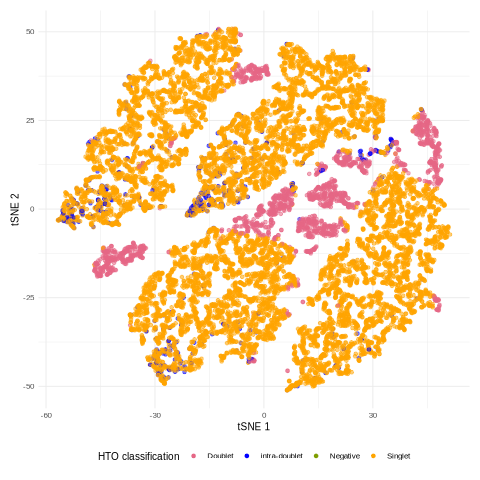

In [9]:
%%R
print(paste0('Number of intra-doublets : ',table(seurat_unfiltered_metadata[['HTO_globalClass']])[['intra-doublet']]))
make_plot_htotsne(seurat_unfiltered_metadata)

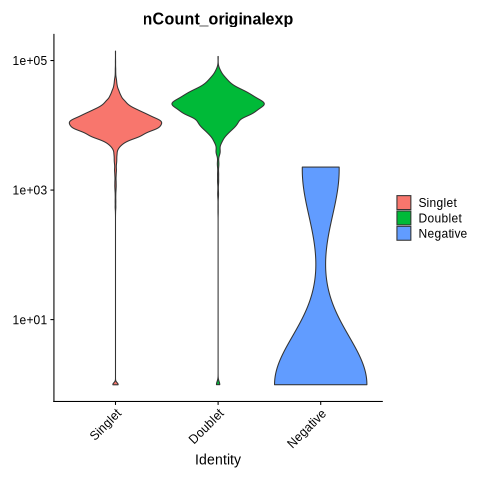

In [12]:
%%R
Idents(sobj) <- "HTO_globalClass"
VlnPlot(sobj, features = "nCount_originalexp", pt.size = 0, log = TRUE)

# Aggregate spliced/unspliced counts to adata object

In [13]:
def buildAnndataFromStarCurr(path):
    """Generate an anndata object from the STAR aligner output folder"""
    path=path
    # Load Read Counts
    X = sc.read_mtx(path+'Gene/raw/matrix.mtx')

    # Transpose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects
    X = X.X.transpose()

    # Load the 3 matrices containing Spliced, Unspliced and Ambigous reads
    mtxU = np.loadtxt(path+'Velocyto/raw/unspliced.mtx', skiprows=3, delimiter=' ')
    mtxS = np.loadtxt(path+'Velocyto/raw/spliced.mtx', skiprows=3, delimiter=' ')
    mtxA = np.loadtxt(path+'Velocyto/raw/ambiguous.mtx', skiprows=3, delimiter=' ')

    # Extract sparse matrix shape informations from the third row
    shapeU = np.loadtxt(path+'Velocyto/raw/unspliced.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)
    shapeS = np.loadtxt(path+'Velocyto/raw/spliced.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)
    shapeA = np.loadtxt(path+'Velocyto/raw/ambiguous.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)

    # Read the sparse matrix with csr_matrix((data, (row_ind, col_ind)), shape=(M, N))
    # Subract -1 to rows and cols index because csr_matrix expects a 0 based index
    # Traspose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects

    spliced = sp.csr_matrix((mtxS[:,2], (mtxS[:,0]-1, mtxS[:,1]-1)), shape = shapeS).transpose()
    unspliced = sp.csr_matrix((mtxU[:,2], (mtxU[:,0]-1, mtxU[:,1]-1)), shape = shapeU).transpose()
    ambiguous = sp.csr_matrix((mtxA[:,2], (mtxA[:,0]-1, mtxA[:,1]-1)), shape = shapeA).transpose()

    # Load Genes and Cells identifiers
    obs = pd.read_csv(path+'Velocyto/raw/barcodes.tsv',
                  header = None, index_col = 0)

    # Remove index column name to make it compliant with the anndata format
    obs.index.name = None

    var = pd.read_csv(path+'Velocyto/raw/features.tsv', sep='\t',
                                    names = ('gene_ids', 'feature_types'), index_col = 1)
  
    # Build AnnData object to be used with ScanPy and ScVelo
    adata = anndata.AnnData(X = X, obs = obs, var = var,
                                                 layers = {'spliced': spliced, 'unspliced': unspliced, 'ambiguous': ambiguous})
    adata.var_names_make_unique()

    return adata.copy()

In [14]:
spliced_adata = buildAnndataFromStarCurr("Starsolo/Solo.out/")

In [15]:
# Ensure the barcode naming pattern is consistent between datasets 
spliced_adata.obs_names = [barcode + '-1' for barcode in spliced_adata.obs_names]
print(adata.shape)
print(spliced_adata.shape)
# Subset so that both datasets contains same barcodes
spliced_adata = spliced_adata[spliced_adata.obs_names.isin(adata.obs_names)]

print(list(set(spliced_adata.var_names)-set(adata.var_names)))

adata = scv.utils.merge(adata, spliced_adata)

(14071, 36385)
(14086, 36379)
[]


In [20]:
adata.obs

,sampleID,diff_batch,diff_batch_2,day,nCount_HTO,nFeature_HTO
CAATGACCATCATTTC-1,Doublet,Double,NaN,Doublet,609.0,4
TCCTCTTTCTGGCCAG-1,ZA60-ARC-d16-AGTAAGTTCAGCGTA,ZA60,batch-3,AGTAAGTTCAGCGTA,1115.0,4
CATGGTAGTGACAGGT-1,ZA60-ARC-d16-AGTAAGTTCAGCGTA,ZA60,batch-3,AGTAAGTTCAGCGTA,925.0,4
GGAACCCAGACTTCAC-1,ZA60-ARC-d16-AGTAAGTTCAGCGTA,ZA60,batch-3,AGTAAGTTCAGCGTA,711.0,4
TTGCATTCAATAACGA-1,Doublet,Double,NaN,Doublet,1511.0,4
...,...,...,...,...,...,...
ACTCTCGAGCACCCAC-1,ZA58-ARC-d16-TGATGGCCTATTGGG,ZA58,batch-1,TGATGGCCTATTGGG,1403.0,4
CAACAGTGTTACCTGA-1,ZA58-ARC-d16-TGATGGCCTATTGGG,ZA58,batch-1,TGATGGCCTATTGGG,675.0,4
CGAGGAAGTCGACTGC-1,ZA59-ARC-d16-TTCCGCCTCTCTTTG,ZA59,batch-2,TTCCGCCTCTCTTTG,588.0,4
TGACCCTCACCTGATA-1,Doublet,Double,NaN,Doublet,1088.0,4


# QC and filtering

In [13]:
adata = adata[~adata.obs['sampleID'].isin(["Doublet", "Negative"])]
#adata.var = adata_var_meta.loc[list(set(adata_var_meta.index) & set(adata.var_names))]

# remove hashtag from the sample id
adata.obs['sampleID'] = adata.obs['sampleID'].map(lambda x:x[0:x.rfind('-')])

In [19]:

# Add diff protocol, timepoint, and condition to pandas df
adata.obs['diff_batch'] = adata.obs['sampleID'].map(lambda x:x[0:x.find('-')]).values
adata.obs['day'] = adata.obs['sampleID'].map(lambda x:x[x.rfind('-')+1:]).values

adata = adata[~adata.obs['diff_batch'].isin(["ZA57"])]

# Rename the protocols 
protocol_dict = {'ZA58':'batch-1', 'ZA59': 'batch-2', 'ZA60': 'batch-3'}
adata.obs['diff_batch_2'] = adata.obs['diff_batch'].map(protocol_dict)

# Remove unnecessary data from adata
del adata.obsm
adata.obs = adata.obs[['sampleID','diff_batch','diff_batch_2', 'day', 'nCount_HTO', 'nFeature_HTO']]


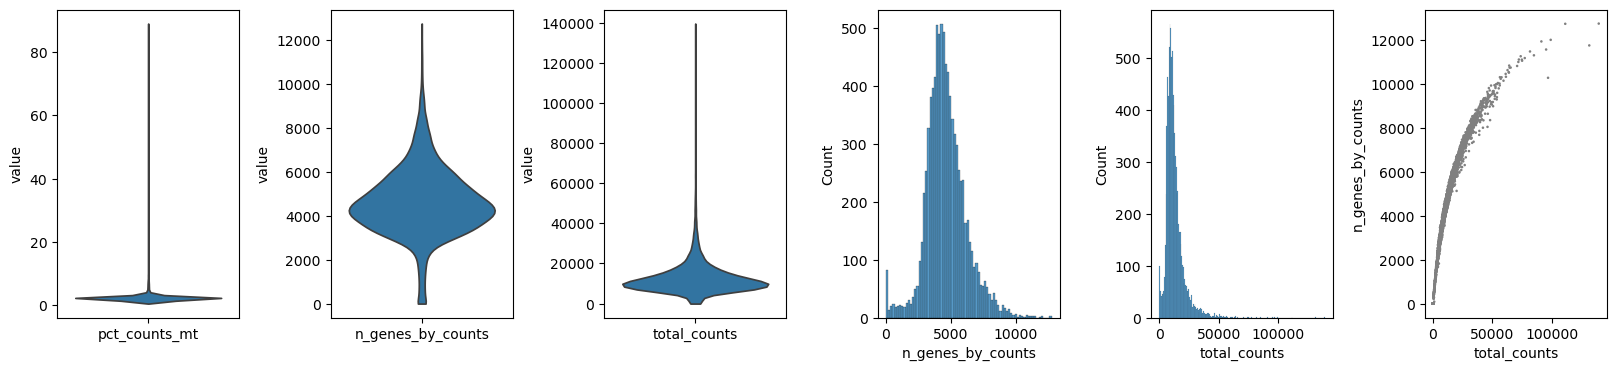

In [15]:
# Compute qc metrix
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [16]:
# perform fitering
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=1400)
sc.pp.filter_cells(adata, max_counts=40000)
sc.pp.filter_cells(adata, min_genes=1400)
sc.pp.filter_cells(adata, max_genes=12300)
adata = adata[adata.obs.pct_counts_mt <4, :] # Remove cells with high mito content

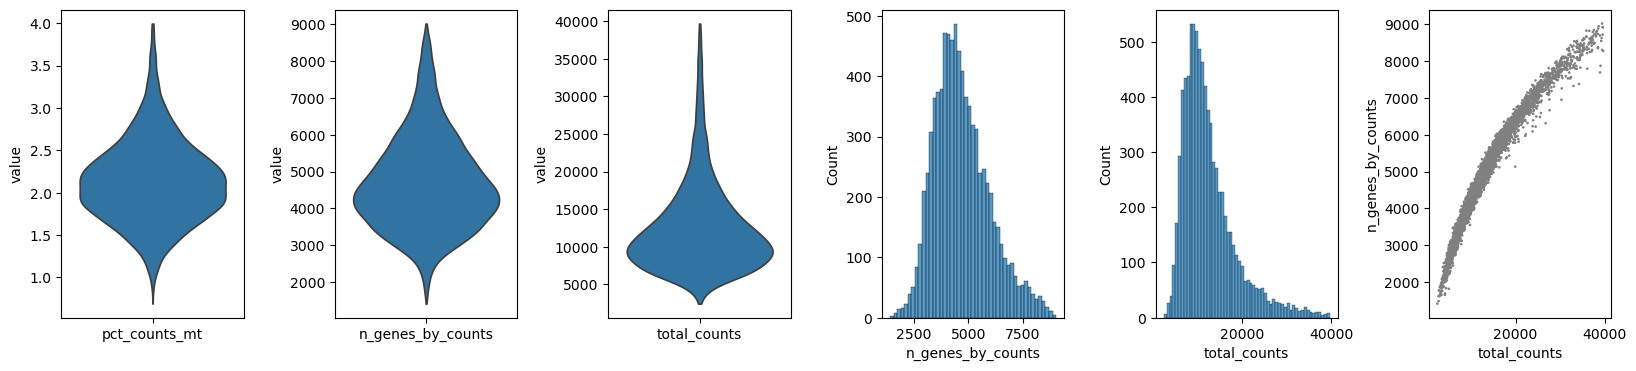

In [17]:
# Compute qc metrix
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [18]:
adata

AnnData object with n_obs × n_vars = 8392 × 29890
    obs: 'sampleID', 'diff_batch', 'diff_batch_2', 'day', 'nCount_HTO', 'nFeature_HTO', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    layers: 'counts', 'spliced', 'unspliced', 'ambiguous'

In [19]:
ribo = adata.var_names.str.startswith(('RPL', "RPS"))
mito = adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
adata = adata[:,adata.var[keep].index]

adata.layers["counts"] = adata.X.copy()

# Normalization, dimensionality reduction and clustering

In [20]:
# Normalizing and log-transforming the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_transformed'] = adata.X.copy()
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata

AnnData object with n_obs × n_vars = 8392 × 29777
    obs: 'sampleID', 'diff_batch', 'diff_batch_2', 'day', 'nCount_HTO', 'nFeature_HTO', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'spliced', 'unspliced', 'ambiguous', 'log_transformed'

In [79]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.4)

In [ ]:
with plt.rc_context({ "figure.dpi": 600, }):
    #sc.pl.umap(adata, color=['sampleID'], ncols=1)
    sc.pl.umap(adata, color=['leiden', 'FOXG1','POMC', 'DLX6-AS1','OTP','STMN2', 'CRABP1','COL1A1'], ncols=2, use_raw=False,legend_loc='on data', cmap='jet', frameon=False, colorbar_loc=None)
    

In [3]:
adata.obs['Cell_types'] = 'Unassigned'

arc_pre = pd.Series(list(adata[adata.obs["leiden"].isin(['5','3','4'])].obs.index), dtype="category")
adata.obs["Cell_types"].loc[arc_pre] = "STMN2+ neurons"

optic = pd.Series(list(adata[adata.obs["leiden"].isin(['6'])].obs.index), dtype="category")
adata.obs["Cell_types"].loc[optic] = "Optic area progenitors"

prog = pd.Series(list(adata[adata.obs["leiden"].isin(['0','1','2'])].obs.index), dtype="category")
adata.obs["Cell_types"].loc[prog] = "Tuberal progenitors"

In [4]:
# Split the FOXG1+ population from the FOXG1- population in cluster 7
adata_7 = adata[adata.obs.leiden.isin(['7'])].copy()
sc.tl.leiden(adata_7, resolution=0.1)

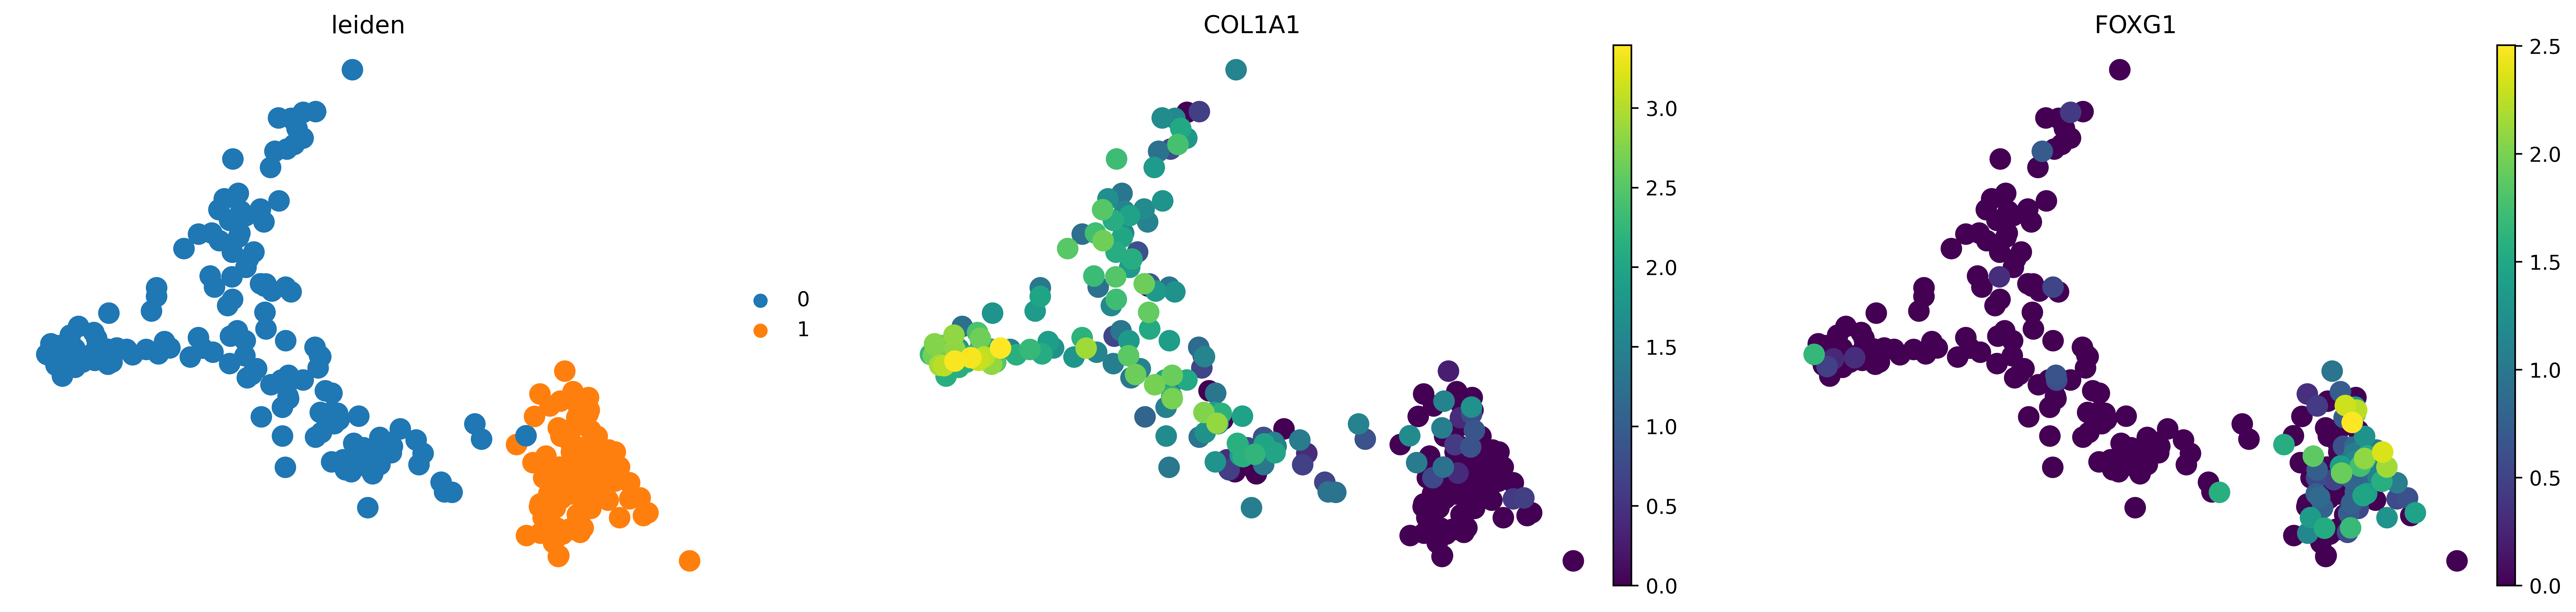

In [5]:
with plt.rc_context({ "figure.dpi": 600, }):
    sc.pl.umap(adata_7, color=['leiden','COL1A1','FOXG1'], ncols=3,  frameon=False)

In [6]:
vlmc = pd.Series(list(adata_7[adata_7.obs["leiden"].isin(['0'])].obs.index), dtype="category")
adata.obs["Cell_types"].loc[vlmc] = "Unassigned"

tele = pd.Series(list(adata_7[adata_7.obs["leiden"].isin(['1'])].obs.index), dtype="category")
adata.obs["Cell_types"].loc[tele] = "Telencephalic progenitors"

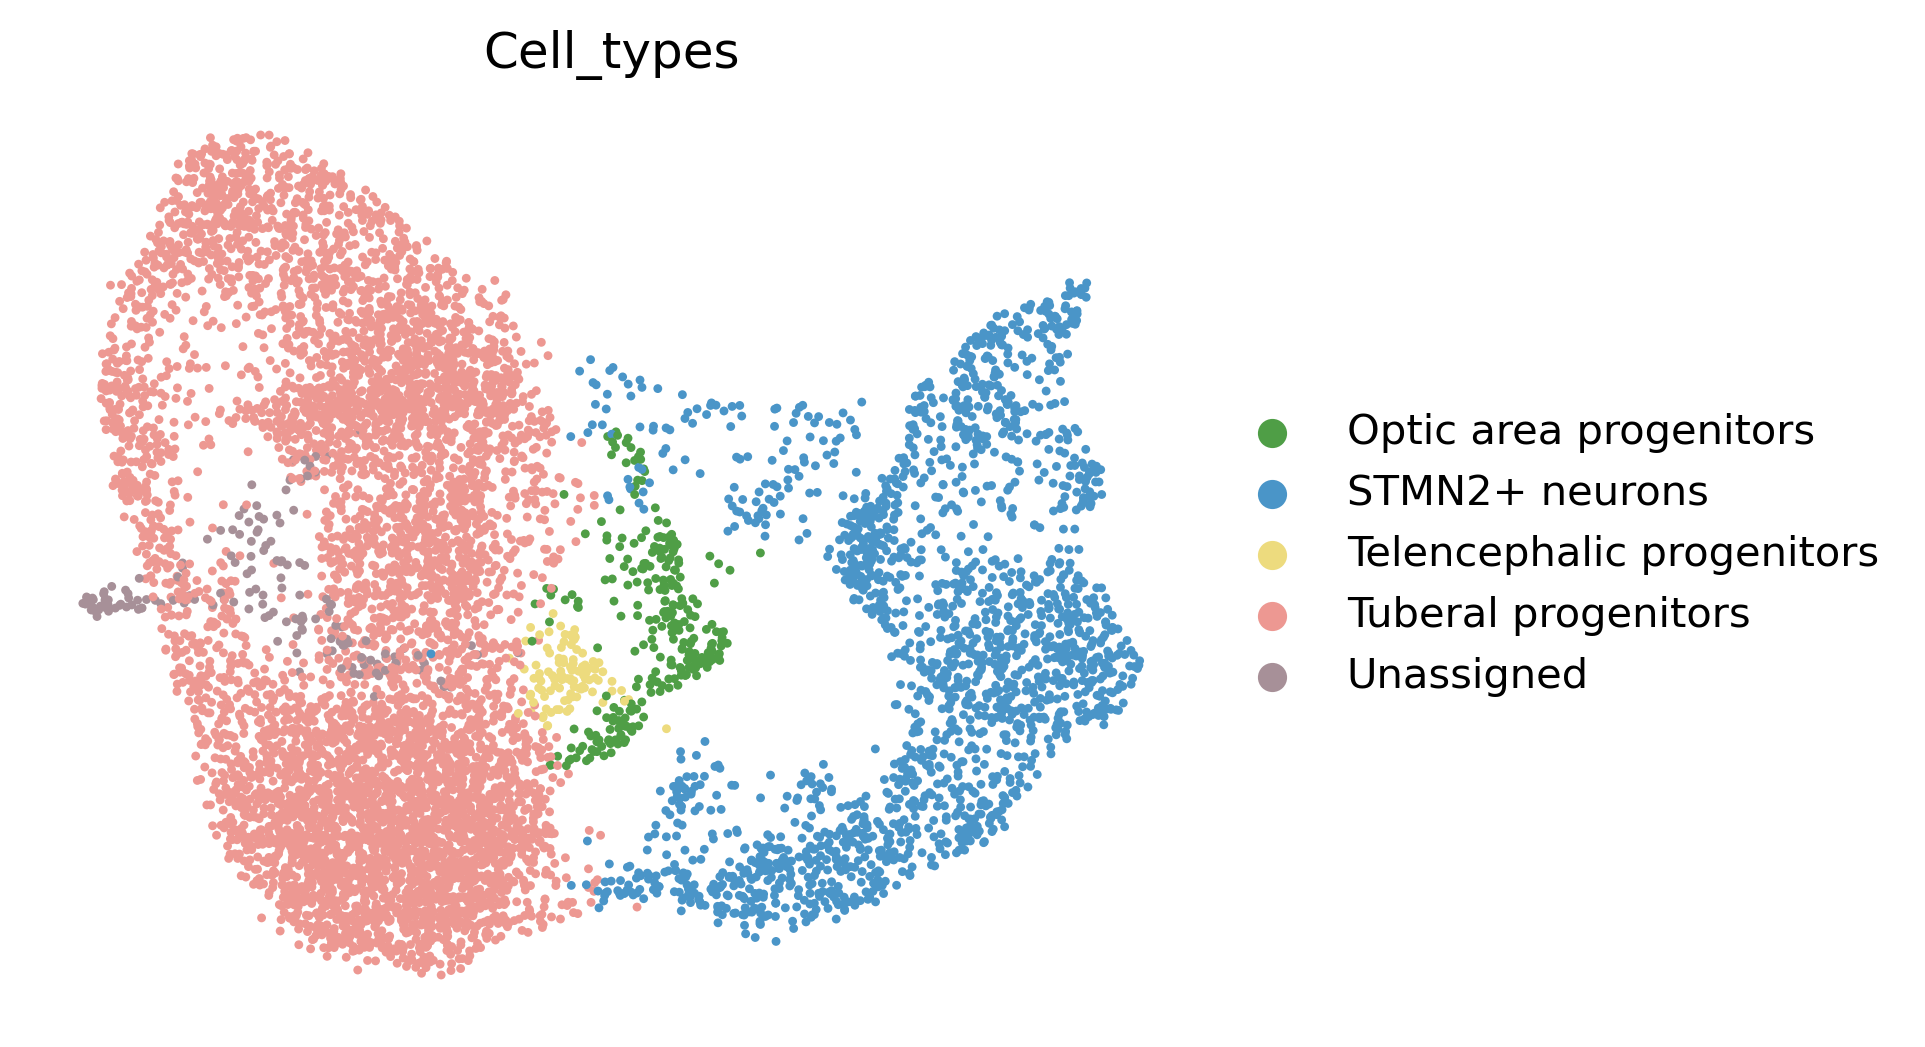

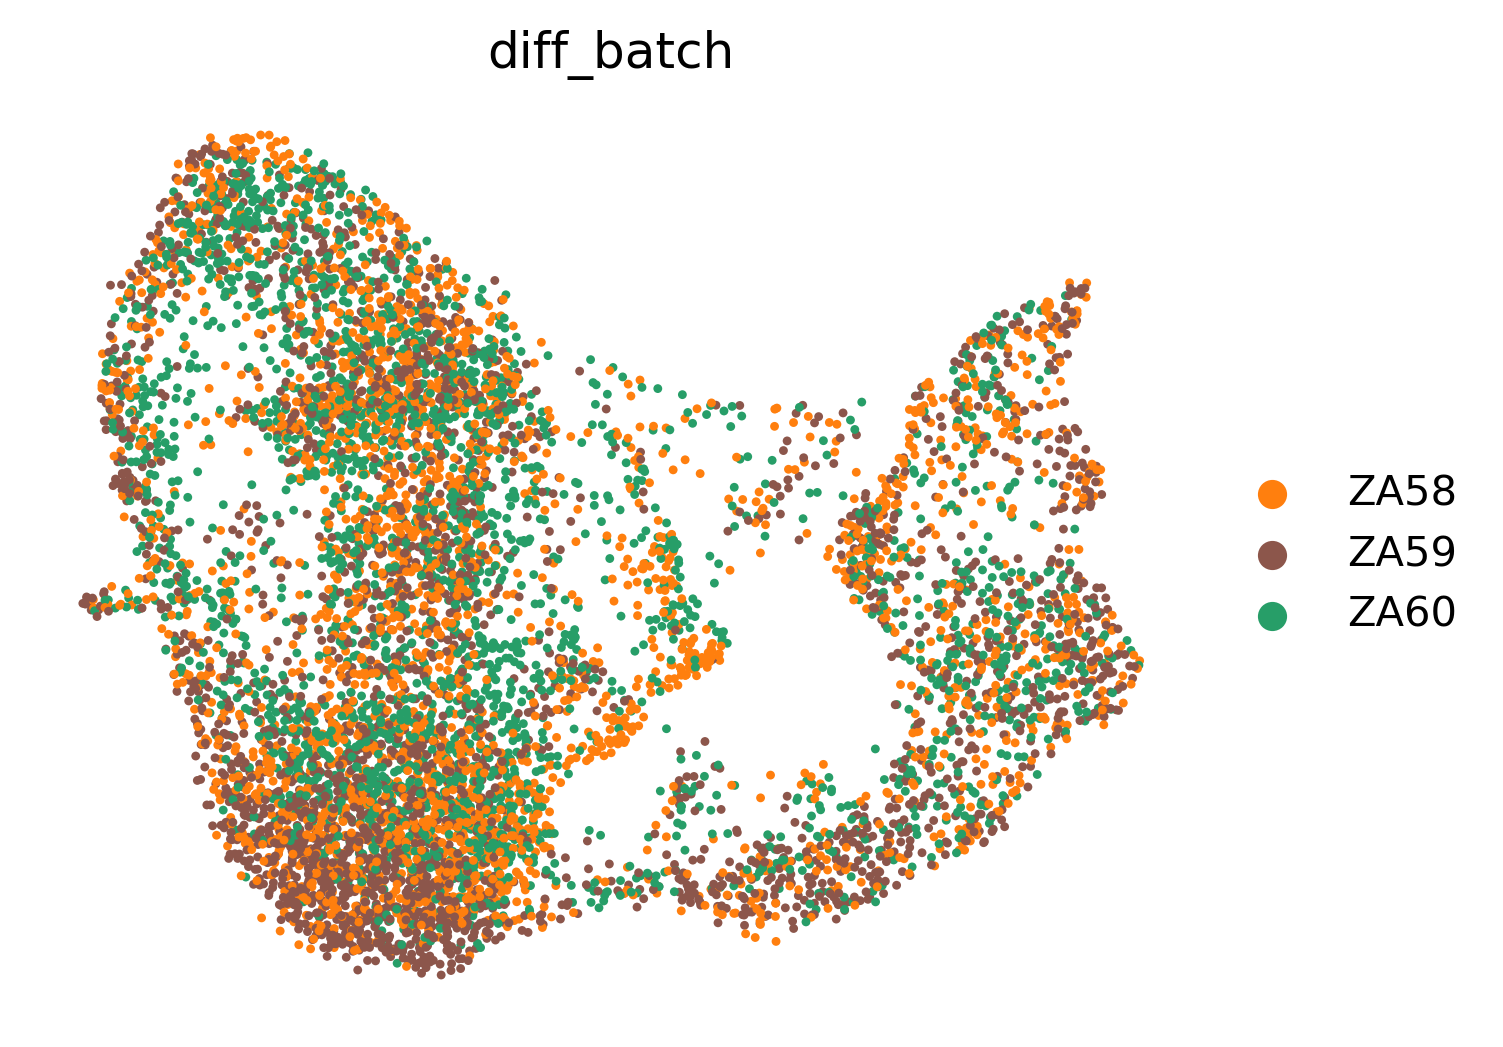

In [16]:
palette_cell_types = ['#4F9E46','#4a95c8','#EDDB7E','#ED9892','#a79098']

with plt.rc_context({ "figure.dpi": 300, "figure.figsize": (5,4) }):
    sc.pl.umap(adata, color=['Cell_types'],palette=palette_cell_types, ncols=2, use_raw=False, cmap='jet', frameon=False, colorbar_loc=None,size=18)
    
palette_batch=['#ff7f0eff', '#8c564bff', '#279e68ff']
with plt.rc_context({ "figure.dpi": 300, "figure.figsize": (5,4) }):
    sc.pl.umap(adata, color=['diff_batch'],palette=palette_batch, ncols=2, use_raw=False, cmap='jet', frameon=False, colorbar_loc=None,size=18)


In [ ]:
adata.write('Data/adata_d16_annotated.h5ad')